# Cubic Equations of State

THis type of equation of state revolves around finding the compressibility factor $Z$ to correct the ideal gas law

$$
\rho = \frac{p}{RTZ},
$$

and obtain the density (and other thermodynamic properties) of a real fluid.

Cubic equations of state model the compressibility factor as a root of a normalized cubic polynomial

$$
Z^3 + c_2(A,B) Z^2 + c_1(A,B) Z + c_0(A, B) = 0,
$$

where the coefficients depend on dimensionless cohesion $A$ and covolume $B$, which in return depend on pressure, temperature and partial fractions.

PorePy provides functionality for finding the real roots of real cubic polynomials and derivatives of the roots with respect to the coefficients, and consequently $A,B$ and their dependencies.

This tutorial demonstrates the functionality and provides an example for a cubic EoS, the Peng-Robinson equation of state.
It also introduces compiled EoS computations and explains the rational behind the API.

### Table of contents

1. [Solving real cubic polynomials](#solving-real-cubic-polynomials)
2. [Compiled Equations of State](#compiled-equations-of-state)
3. [Example: Peng-Robinson EoS](#example-peng-robinson-eos)
    1. [Extended compressibility factors](#extended-compressibility-factors)
4. [Conclusion](#conclusion)

## Solving real cubic polynomials

The roots are obtained by providing coefficients $c_2, c_1, c_0$.
By calculating the discriminant, we can determine the number of real roots and their algebraic multiplicity.
There are 4 cases:

1. Single real root with multiplicity 3 (triple root).
1. Single real root and two complex-conjugated roots.
3. Two distinct real roots where one of them has multiplicity 2.
4. Three distinct real roots.

PorePy's approach is to determin the root case and apply the correct trigonometric formula to obtain the real root.

In [1]:
### SEE SECTION ON PENG-ROBINSON ON HOW TO USE BELOW TWO LINES.
# import os
# os.environ["NUMBA_DISABLE_JIT"] = "1"
###

import porepy.compositional.peng_robinson.cubic_polynomial as cp

c2 = 1.0
c1 = -10
c0 = 0.5

eps = 1e-14  # For determining degenerate discriminant.

r = cp.calculate_roots(c2, c1, c0, eps)

case = cp.get_root_case(c2, c1, c0, eps)

map_to_base_func = {
    0: cp.triple_root,
    1: cp.two_roots,
    2: cp.one_root,
    3: cp.three_roots,
}

if case in [0, 1]:
    assert r.size == 1
else:
    assert r.size == case

print(r)
print(map_to_base_func[case](c2, c1, c0))

[-3.72247101  0.05026536  2.67220564]
[-3.72247101  0.05026536  2.67220564]


As evident, the general function `calculate_roots` provides the same result as the base function.
In every root case, *the returned roots are ordered by size* starting with the smallest.

Another feature is that we can calculate the derivatives of the roots with respect to the coefficients.
We obtain a 2D array, which is assentialy the Jacobian of $r(c_2, c_1, c_0)$.
Note however that $r$ and the Jacobian change size. The number of rows always corresponds to the number of roots.

Consequently, smoothness of the Jacobian across borders between root cases is no guaranteed.

In [2]:
print(cp.calculate_root_derivatives(c2, c1, c0, eps))
print('---')
print(cp.calculate_roots(0, 1, 1, eps))
print(cp.calculate_root_derivatives(0, 1, 1, eps))

[[-5.74364514e-01  1.54296572e-01 -4.14500399e-02]
 [ 2.55422030e-04  5.08147214e-03  1.01092921e-01]
 [-4.25890908e-01 -1.59378044e-01 -5.96428812e-02]]
---
[-0.6823278]
[[-0.194254    0.28469308 -0.41723799]]


## Compiled Equations of State

[CompiledEoS](../src/porepy/compositional/compiled_eos.py#638) is a child class of the general [EquationOfState](../src/porepy/compositional/base.py#340) providing a compiled framework for wrapping individual phase property computations.

The main ideas are the following:

1. The signature of phase property functions and their derivative is simply and clearly defined for a single evaluation (pressure, temperature and partial fraction values).
2. Costly computations which are needed for each property (like the compressibility factor) are bundled into a "pre-argument", which is computed only once and passed to all property functions.
3. The base class takes care of vectorization once the property functions are implemented according to the template. I.e., the user needs only to overload some factory methods which provide functions for each property.

The analytic expressions for phase properties like density or enthalpy contain all the value for cohesion, covolume and compressibility factor.
It's enough to compute those values once and then do the rest.
The pre-argument is meant for such computations.
There is a pre-argument for phase properties, and an additional pre-argument for phase property derivatives.
The latter might need derivatives of $Z$ with respect to temperature for example.
Those computations are expensive as well and only performed for the evaluation of derivatives.

A pre-argument is in principle a 1D array of floats containing relevant values.
When creating such functions for a chid class of `CompiledEoS`, use the provided numba signatures to ensure compatibility with the vectorization:

In [3]:
from porepy.compositional.compiled_eos import (
    PREARGUMENT_FUNC_SIGNATURE,
    PROPERTY_FUNC_SIGNATURE,
    PROPERTY_DERIVATIVE_FUNC_SIGNATURE,
    FUGACITY_COEFF_FUNC_SIGNATURE,
    FUGACITY_COEFF_DERIVATIVE_FUNC_SIGNATURE,
)

print(PREARGUMENT_FUNC_SIGNATURE)
print(PROPERTY_FUNC_SIGNATURE)
print(FUGACITY_COEFF_DERIVATIVE_FUNC_SIGNATURE)

(IntEnum<int64>(PhysicalState), float64, float64, Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True)) -> array(float64, 1d, A)
(Array(float64, 1, 'A', False, aligned=True), float64, float64, Array(float64, 1, 'A', False, aligned=True)) -> float64
(Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True), float64, float64, Array(float64, 1, 'A', False, aligned=True)) -> array(float64, 2d, A)


The preargument function takes the following arguments:

1. the physical state of the phase (see [CompiledEoS.compute_phase_properties](../src/porepy/compositional/compiled_eos.py#1008)),
2. a pressure value,
3. a temperature value,
4. partial fraction values (per component in phase),
5. a paramater array containing anything else relevant for the compuation.

Both the property function signature and the fugacity coefficient signature take

1. a 1D array representing the pre-argument for value evaluation,
2. a pressure value,
3. a temperature value,
4. a 1D array containing partial fractions.

The difference is, that properties are expected to return a float, while fugacity coefficients return a 1D array of coefficients per component.

You can learn more about the signatures in the respective documentation.
The `CompiledEoS` class provides an abstract interface for where to implement the property functions.

## Example: Peng-Robinson EoS

PorePy contains the classical Peng-Robinson equation of state in compiled form.
We provide here some information on how to set up the EoS.
It can then subsequently be used in `get_phase_configuration` when creating a flow model with a complex fluid (see [tutorial on fluid modeling](fluid_modeling.ipynb)).

Let us create an EoS instance with three components, water, hydrogen sulfide and carbon dioxide.
The EoS requires a couple of physical parameters in order to work properly.
We see immediatly that real fluid modeling requires quite some effort, as well as third-party data.
There are some utility functions available, but they require packages which are not by default installed with PorePy's dependencies.

Note that in any case we need some interpolated data from experimental measurements to obtain ideal enthalpy values.
The sub-package provides those for some basic fluid components found in the subsurface.

Note also that the entire subpackage `compositional` operates on base SI units.

In [4]:
import numpy as np
import numba as nb
import porepy as pp
import porepy.compositional.peng_robinson as pr
from porepy.compositional.compiled_eos import ScalarFunction, VectorFunction

# Basic component paramters
try:
    import chemicals
except ModuleNotFoundError:
    h2o = pp.compositional.FluidComponent(
        name="H2O",
        acentric_factor=0.3443,
        critical_pressure=22064000.0,
        critical_specific_volume=5.59480372671e-05,
        critical_temperature=647.096,
        molar_mass=0.01801528,
    )
    h2s = pp.compositional.FluidComponent(
        name="H2S",
        acentric_factor=0.1005,
        critical_pressure=9000000.0,
        critical_specific_volume=9.81354268891e-05,
        critical_temperature=373.1,
        molar_mass=0.03408088,
    )
    co2 = pp.compositional.FluidComponent(
        name="CO2",
        acentric_factor=0.22394,
        critical_pressure=7377300.0,
        critical_specific_volume=9.41184770731e-05,
        critical_temperature=304.1282,
        molar_mass=0.04400950000000001,
    )
    components = [h2o, h2s, co2]
# Chemicals is not part of PorePy's dependencies.
# If you have it anyhow, below is a handy utility.
else:
    components = pp.compositional.load_fluid_constants(
        ["H2O", "H2S", "CO2"], package="chemicals"
    )

# Binary interaction paramters between components, a symmetric matrix.
try:
    import thermo
except ModuleNotFoundError:
    bips = np.array(
        [
            [0.0, 0.0394, 0.0952],
            [0.0394, 0.0, 0.0967],
            [0.0952, 0.0967, 0.0],
        ]
    )
else:
    bips = pr.get_bip_matrix(components, package="thermo")

# Some function representing the ideal part.
h_ideal = [pr.h_ideal_H2O, pr.h_ideal_H2S, pr.h_ideal_CO2]

for c in components:
    print(c)
print(bips)

FluidComponent(name='H2O', units=<porepy.models.units.Units object at 0x00000262AEE63A10>, constants_in_SI={'acentric_factor': 0.3443, 'compressibility': 0.0, 'critical_pressure': 22064000.0, 'critical_specific_volume': 5.59480372671e-05, 'critical_temperature': 647.096, 'density': 1.0, 'molar_mass': 0.01801528, 'normal_thermal_conductivity': 1.0, 'thermal_conductivity': 1.0, 'thermal_expansion': 0.0, 'specific_heat_capacity': 1.0, 'viscosity': 1.0}, _initialized=True, acentric_factor=0.3443, compressibility=0.0, critical_pressure=22064000.0, critical_specific_volume=5.59480372671e-05, critical_temperature=647.096, density=1.0, molar_mass=0.01801528, normal_thermal_conductivity=1.0, thermal_conductivity=1.0, thermal_expansion=0.0, specific_heat_capacity=1.0, viscosity=1.0)
FluidComponent(name='H2S', units=<porepy.models.units.Units object at 0x00000262AF19D090>, constants_in_SI={'acentric_factor': 0.1005, 'compressibility': 0.0, 'critical_pressure': 9000000.0, 'critical_specific_volume

The Compiled Peng-Robinson class contains implementations for thermodyanmic state functions (phase properties).
But for flow and transport, we also require transport properties such as viscosities and thermal conductivities.

Transport properties are a whole research area on their own.
Below we demonstrate how to use the framework to implement some functions returning constant values.

For more information on the physical state enum, see [its implementation](../src/porepy/compositional/_core.py#227).

In [5]:
class MyEoS(pr.CompiledPengRobinson):
    def get_viscosity_function(self) -> ScalarFunction:
        @nb.njit(PROPERTY_FUNC_SIGNATURE)
        def mu_c(prearg: np.ndarray, p: float, T: float, xn: np.ndarray) -> float:
            # Reading up on the base class, the preargument contains the physical state
            # value as last entry.
            state = prearg[-1]
            if state == 1.0:  # liquid-like
                mu = 1e-3
            elif state == 10.0:  # gas-like
                mu = 1e-5
            else:
                raise ValueError(f"Uncovered physical state {int(state)}")

            return mu

        return mu_c

    def get_viscosity_derivative_function(self) -> VectorFunction:
        @nb.njit(PROPERTY_DERIVATIVE_FUNC_SIGNATURE)
        def dmu_c(
            prearg_val: np.ndarray,
            prearg_jac: np.ndarray,
            p: float,
            T: float,
            xn: np.ndarray,
        ) -> np.ndarray:
            return np.zeros(2 + xn.shape[0], dtype=np.float64)

        return dmu_c

    def get_conductivity_function(self) -> ScalarFunction:
        @nb.njit(PROPERTY_FUNC_SIGNATURE)
        def kappa_c(prearg: np.ndarray, p: float, T: float, xn: np.ndarray) -> float:
            return 1.0

        return kappa_c

    def get_conductivity_derivative_function(self) -> VectorFunction:
        @nb.njit(PROPERTY_DERIVATIVE_FUNC_SIGNATURE)
        def dkappa_c(
            prearg_val: np.ndarray,
            prearg_jac: np.ndarray,
            p: float,
            T: float,
            xn: np.ndarray,
        ) -> np.ndarray:
            return np.zeros(2 + xn.shape[0], dtype=np.float64)

        return dkappa_c


eos = MyEoS(
    components=components,
    ideal_enthalpies=h_ideal,
    bip_matrix=bips,
)

The equation of state is now set up and almost ready.
We mention here that it has two parameters which enter the phase properties.
**You can modify them before compilation to set their default value**.
After compilation you have to pass them explicitly when computing phase properties, if you want other than default values.

You can read about their meaning in [their documentation](../src/porepy/compositional/peng_robinson/eos.py#660).

In [6]:
print(eos.params)

{'smoothing_multiphase': 0.0001, 'eps': 1e-14}


The last step involves compilation.
This creates efficient machine code for evaluating phase properties, which is tailored to the three components H2O, H2S and CO2.

**It also takes some time.**

In [7]:
import logging
import sys
import time

date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    datefmt=date_strftime_format,
)
logging.getLogger("porepy").setLevel(logging.DEBUG)

s = time.time()
eos.compile()
compile_time = time.time() - s

2025-11-25 10:06:30 Compiling symbolic Peng-Robinson EoS ..
2025-11-25 10:06:30 Compiling symbolic functions 1/12
2025-11-25 10:06:30 Compiling symbolic functions 2/12
2025-11-25 10:06:30 Compiling symbolic functions 3/12
2025-11-25 10:06:31 Compiling symbolic functions 4/12
2025-11-25 10:06:32 Compiling symbolic functions 5/12
2025-11-25 10:06:58 Compiling symbolic functions 6/12
2025-11-25 10:06:58 Compiling symbolic functions 7/12
2025-11-25 10:06:58 Compiling symbolic functions 8/12
2025-11-25 10:07:06 Compiling symbolic functions 9/12
2025-11-25 10:07:06 Compiling symbolic functions 10/12
2025-11-25 10:07:06 Compiling symbolic functions 11/12
2025-11-25 10:07:07 Compiling symbolic functions 12/12
2025-11-25 10:07:07 Compiling property functions ..
2025-11-25 10:07:08 Compiling property functions 1/14
2025-11-25 10:07:11 Compiling property functions 2/14
2025-11-25 10:07:11 Compiling property functions 3/14
2025-11-25 10:07:12 Compiling property functions 4/14
2025-11-25 10:07:12 C

Let's now see what all the effort is about.

In [8]:
N = 1000000
p = np.random.random((N,)) * 5e6 + 1e7
T = np.random.random((N,)) * 100 + 300.
x = np.random.random((3, N))
x = pp.compositional.normalize_rows(x.T).T
assert np.allclose(x.sum(axis=0), 1.0)

s = time.time()
props_liq = eos.compute_phase_properties(pp.compositional.PhysicalState.liquid, p, T, x)
props_gas = eos.compute_phase_properties(pp.compositional.PhysicalState.gas, p, T, x)
print(f"Elapsed time computation: {time.time() - s} (s)")
print(f"Elapsed time compilation: {compile_time} (s)")

Elapsed time computation: 6.180466651916504 (s)
Elapsed time compilation: 44.05277109146118 (s)


Now, to compare the compiled computation with non-compiled computations go to the first code cell and uncomment the two lines importing `os` and setting the flag to disable numba.
Run the script again and compare the times.
Instead of X minutes, our computations take now only few seconds, for both gas- and liquid-like phase.
As `N` increases, the non-compiled computations take more time than compilation and compiled computation combined, which is of course machine-dependent.

For PorePy applications however, it is in any case relevant.
Imagine `N` being the number of cells in a computational domain and the benefits become clear.

Let us inspect some of the results.

In [9]:
print(props_liq.h.shape)
print(props_liq.dh.shape)
print(props_liq.dphis.shape)

(1000000,)
(5, 1000000)
(3, 5, 1000000)


The properties contain the values corresponding to the rows of the input arguments.
Property derivatives contain them per column. The rows are related to the dependencies.

- `props_liq.dh[0]` contains the derivative of the liquid enthalpy with respect to pressure.
- `props_liq.dh[4]` contains the derivative with respect to the partial fraction of CO2.
- `props_liq.dphis[0, 1, :]` contains the derivatives of the fugacity coefficient of H2O (index 0) with respect to temperature (index 1).


Let us compare the compressibility factors.
Their computation is part of the pre-argument.
We can access individual computations by using the `gufuncs` attribute of the `eos` for vectorized computations, `funcs` for scalar computations.
However, when we call it we have to respect the signature of the compiled function.
First, the vectorization is executed over rows, which means we need to transpose `x`.
And second, the pre-argument function expects some parameters. To pass none, we have to pass an empty array and the function will internally resort to the default params in `eos.params`.
All this happens in the background of `compute_phase_properties`.

In [10]:
params = np.zeros((N, 0))

Z_liq = eos.gufuncs["prearg_val"](
    pp.compositional.PhysicalState.liquid, p, T, x.T, params
)[:, 2]
Z_gas = eos.gufuncs["prearg_val"](
    pp.compositional.PhysicalState.gas, p, T, x.T, params
)[:, 2]

assert np.all(Z_gas >= Z_liq)

As expected, the compressibility factor of the gas is in all cases greater or equal than the compressibility factor of the liquid.

### Extended compressibility factors.

The presented Peng-Robinson EoS is *extended*. It can provide compressibility factors for both phases in areas in the pressure-temperature space, where these phases are not physically present.
These extended compressibility factors are used for the persistent variable flash, but they are nor real roots of the cubic polynomial of the EoS.

To show that, let us plot the residuals of the polynomial.

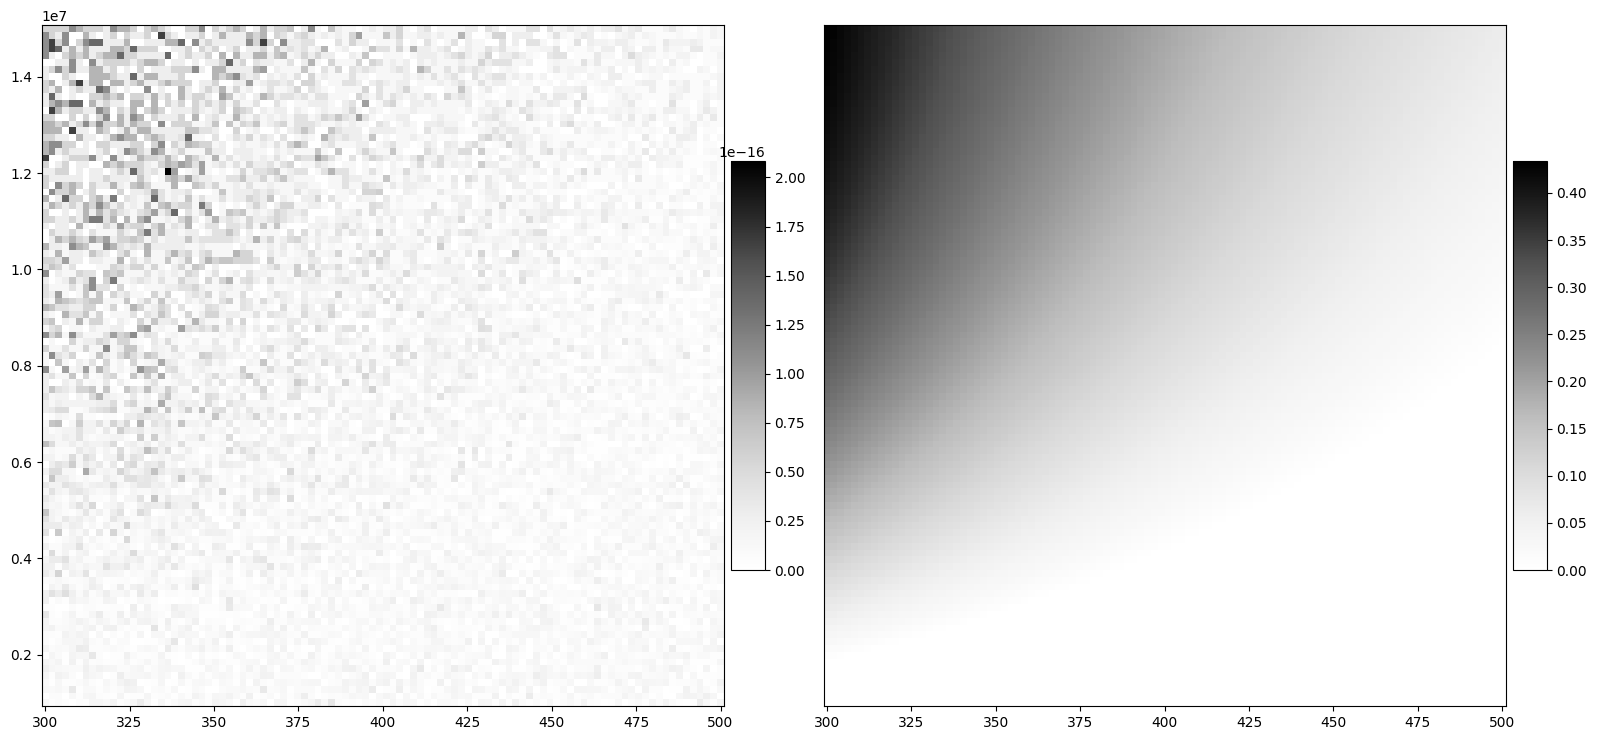

In [11]:
N = 100
p = np.linspace(1e6, 15e6, N, endpoint=True)
T = np.linspace(300.0, 500.0, N, endpoint=True)
Tm, pm = np.meshgrid(T, p)
p = pm.flatten()
T = Tm.flatten()
x = np.ones_like(T)
x = np.vstack([x * 0.95, x * 0.025, x * 0.025])
params = np.zeros((p.shape[0], 0))
assert np.allclose(x.sum(axis=0), 1.0)

prearg_liq = eos.gufuncs["prearg_val"](
    pp.compositional.PhysicalState.liquid, p, T, x.T, params
)
prearg_gas = eos.gufuncs["prearg_val"](
    pp.compositional.PhysicalState.gas, p, T, x.T, params
)

A_l = prearg_liq[:, 0]
B_l = prearg_liq[:, 1]
Z_l = prearg_liq[:, 2]

A_g = prearg_gas[:, 0]
B_g = prearg_gas[:, 1]
Z_g = prearg_gas[:, 2]

res_l = np.abs(
    Z_l**3
    + (B_l - 1) * Z_l**2
    + (A_l - 2 * B_l - 3 * B_l**2) * Z_l
    + B_l**3
    + B_l**2
    - A_l * B_l
)
res_g = np.abs(
    Z_g**3
    + (B_g - 1) * Z_g**2
    + (A_g - 2 * B_g - 3 * B_g**2) * Z_g
    + B_g**3
    + B_g**2
    - A_g * B_g
)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 7.5))
ax = fig.add_subplot(1, 2, 1)
img = ax.pcolormesh(Tm, pm, res_l.reshape(Tm.shape), cmap="Greys", shading="nearest")
cax = ax.inset_axes((1.01, 0.2, 0.05, 0.6))
fig.colorbar(img, ax=ax, cax=cax, orientation="vertical")

ax = fig.add_subplot(1, 2, 2)
img = ax.pcolormesh(Tm, pm, res_g.reshape(Tm.shape), cmap="Greys", shading="nearest")
ax.set_yticks([])
cax = ax.inset_axes((1.01, 0.2, 0.05, 0.6))
fig.colorbar(img, ax=ax, cax=cax, orientation="vertical")
fig.tight_layout()

We see that for these pressure, temperature and mass values, the liquid root is always a real root.
This is a hint that there is always a liquid-like phase present.
The gas-like phase on the other hand is only present in the lower right part of the range.

However, this is only for demonstration purposes. To obtain the correct picture, the flash must be performed.

## Conclusion

We have seen:

1. How to find the real roots of a real cubic polynomials and how to obtain the derivatives with respect to the coefficients.
2. How to create a compiled equation of state by implementing overloads for individual thermodynamic and transport properties.
3. How to calculate fluid properties for gas and liquid phases using the Peng-Robinson equation of state.